Length of Dataset: 17
Train Size:1  |  Test Size:16
波形形状: torch.Size([8, 2049, 626])
波形采样率: 16000


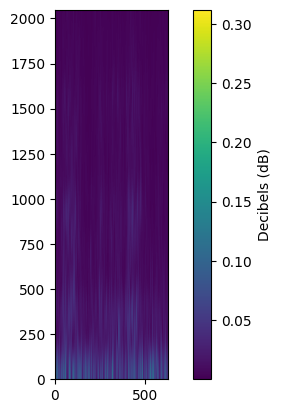

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch_geometric.utils
import torch, random, torchaudio, os, time, math, torch_geometric
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
from torchvision import transforms as transforms
import torchaudio.transforms as audio_transforms
import datasets
from torch.utils.data import random_split, DataLoader
import utils

mimii_dataset_SNR = -6
N, K, query_size = 5, 5, 5
dataset_transform = 'spectrogram'
train_test_ratio = 0.1

args = utils.Args(seed=42, N=N, K=K, query_size=query_size, SNR=mimii_dataset_SNR, transform=dataset_transform)
if args.device != "cpu":
    num_workers = 1
    pin_memory = True
    torch.cuda.manual_seed(args.seed)
else:
    num_workers = 0
    pin_memory = False
    torch.manual_seed(args.seed)

# 加载数据集
mimii_dataset = datasets.MIMII(root_dir=f'./data/mimii/{mimii_dataset_SNR}'+'dB_SNR',
                                N=N, K=K, query_size=query_size, transform=dataset_transform)
print(f"Length of Dataset: {len(mimii_dataset)}")
train_size = int(train_test_ratio * len(mimii_dataset))
test_size = len(mimii_dataset) - train_size
train_set, test_set = random_split(mimii_dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
print(f"Train Size:{train_size}  |  Test Size:{test_size}")

# 可视化一个样本
fig = plt.figure()
waveform_shape = 0
for support_set, _ in train_loader:
    for waveform, label in support_set:
        waveform = waveform.squeeze(0)
        print("波形形状: {}".format(waveform.size()))
        print("波形采样率: {}".format(mimii_dataset.sample_rate))
        if len(waveform.shape) == 3: # 转换过的2D波形
            plt.imshow(waveform[0], origin='lower')
            plt.colorbar(label="Decibels (dB)")
        else: # 1D 纯波形
            plt.plot(waveform[0].T.numpy())
        waveform_shape = waveform.shape
        break
    break

Epoch:1  |  CNN_Loss :1.677
Epoch:2  |  CNN_Loss :2.309
Epoch:3  |  CNN_Loss :1.424
Epoch:4  |  CNN_Loss :1.221
Epoch:5  |  CNN_Loss :1.114
Epoch:6  |  CNN_Loss :0.857
Epoch:7  |  CNN_Loss :0.773
Epoch:8  |  CNN_Loss :0.828
Epoch:9  |  CNN_Loss :0.734
Epoch:10  |  CNN_Loss :0.725
Epoch:11  |  CNN_Loss :0.622
Epoch:12  |  CNN_Loss :0.626
Epoch:13  |  CNN_Loss :0.627
Epoch:14  |  CNN_Loss :0.627
Epoch:15  |  CNN_Loss :0.585
Epoch:16  |  CNN_Loss :0.604
Epoch:17  |  CNN_Loss :0.565
Epoch:18  |  CNN_Loss :0.535
Epoch:19  |  CNN_Loss :0.522
Epoch:20  |  CNN_Loss :0.536
Epoch:21  |  CNN_Loss :0.515
Epoch:22  |  CNN_Loss :0.474
Epoch:23  |  CNN_Loss :0.447
Epoch:24  |  CNN_Loss :0.407
Epoch:25  |  CNN_Loss :0.490
Epoch:26  |  CNN_Loss :0.364
Epoch:27  |  CNN_Loss :0.366
Epoch:28  |  CNN_Loss :0.357
Epoch:29  |  CNN_Loss :0.394
Epoch:30  |  CNN_Loss :0.300
Epoch:31  |  CNN_Loss :0.314
Epoch:32  |  CNN_Loss :0.278


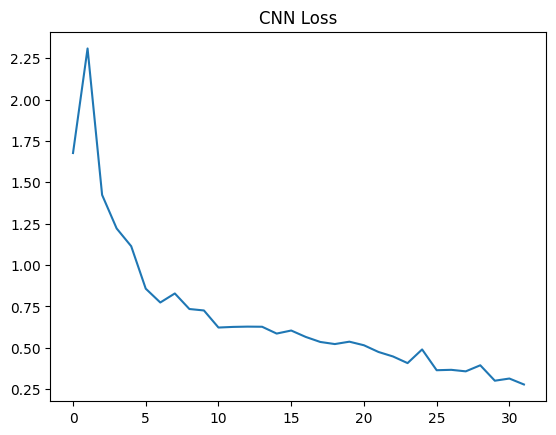

In [2]:
import nets
# CNN训练
cnn_num_hidden_channels = 32
cnn_num_epochs = 32
cnn_lr = 0.1
if args.transform is None:
    cnn = nets.AudioCNN(num_channels_input=waveform_shape[0], 
                        num_channels_hidden=cnn_num_hidden_channels, 
                        num_classes_output=args.N)
else:
    cnn = nets.AudioCNN2D(num_channels_input=waveform_shape[0], 
                        num_channels_hidden=cnn_num_hidden_channels, 
                        num_classes_output=args.N)
    
def cnn_train(cnn, train_loader, num_epochs, lr, args:utils.Args):

    def init_weights(module):
        if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(module.weight)
            #nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')

    optimizer = optim.Adam(cnn.parameters(), lr=lr) # , weight_decay=0.0001
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.65)
    loss_function = nn.CrossEntropyLoss()

    cnn.to(args.device).train()
    cnn.apply(init_weights)
    losses = []

    for epoch in range(1, num_epochs+1):
        metric = utils.Accumulator(2) # 一个epoch经过样本数 cnn一个epoch所有样本损失总量
        for support_set, query_set in train_loader:
            waveforms, labels = [], []
            for waveform, label in support_set:
                waveforms.append(waveform.squeeze(0)),
                labels.append(label)
            for waveform, label in query_set:
                waveforms.append(waveform.squeeze(0)),
                labels.append(label)
            waveforms = torch.stack(waveforms).to(args.device)
            labels = torch.tensor(labels, device=args.device)
            
            optimizer.zero_grad()
            y_hat = cnn(waveforms)
            loss = loss_function(y_hat, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            metric.add(waveforms.shape[0], loss.item())
            del waveforms, labels
            torch.cuda.empty_cache()
        losses.append(metric[1])

        print(f"Epoch:{epoch}  |  CNN_Loss :{losses[-1]:.3f}")
    fig = plt.figure()
    plt.plot(list(range(num_epochs)), losses, label='Loss')
    plt.title('CNN Loss')
    res_folder = f"./Results/{args.N}-way-{args.K}-shots"
    if not os.path.exists(res_folder):
        os.makedirs(res_folder)
    plt.savefig(os.path.join(res_folder, f"{args.SNR}SNR-cnn-train-res-{args.N}-way-{args.K}-shots-"+args.transform))

cnn_train(cnn, train_loader, num_epochs=cnn_num_epochs, lr=cnn_lr, args=args)

In [7]:
def graph_construction(feature_vecs, labels):
    """返回一个torch_geometric.data.Data类, 代表一张图"""
    num_nodes = feature_vecs.shape[0]
    adj_matrix = torch.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                continue
            adj_matrix[i][j] = 1 / torch.sum(torch.pow(feature_vecs[i] - feature_vecs[j], 2), 0)
    edge_index, edge_weight = torch_geometric.utils.dense_to_sparse(adj_matrix)
    return Data(x=feature_vecs, edge_index=edge_index, edge_weight=edge_weight, y=labels)

def to_graph_dataset(cnn:nn.Module, dataloader:torch.utils.data.DataLoader, device):
    """
    Device指的是CNN的device, 而不是最终形成的graph的device\n
    最终的graph会被放在cpu上
    """
    graphs = []
    for support_set, query_set in dataloader:
        waveforms, labels = [], []
        for waveform, label in support_set:
            waveforms.append(waveform.squeeze(0)),
            labels.append(label)
        for waveform, label in query_set:
            waveforms.append(waveform.squeeze(0)),
            labels.append(label)
        waveforms = torch.stack(waveforms).to(device)
        labels = torch.tensor(labels)

        feature_vecs = utils.feature_extraction(cnn, waveforms)
        graph = graph_construction(feature_vecs, labels)
        graphs.append(graph)
    
    return graphs

from torch_geometric.loader import DataLoader as GeometricDataLoader
graphs = to_graph_dataset(cnn, train_loader, device=args.device)
graph_dataset = datasets.GraphDataset(graphs=graphs)
query_size = mimii_dataset.query_size
graph_trainloader = GeometricDataLoader(graph_dataset, batch_size=1, shuffle=True)
print(f"图训练数据集中共有{len(graph_trainloader)}张图")

图训练数据集中共有1张图


Epoch:50  |  GCN_Loss :0.01277  |  Query_Acc:60.00%
Epoch:100  |  GCN_Loss :0.01069  |  Query_Acc:80.00%
Epoch:150  |  GCN_Loss :0.00926  |  Query_Acc:100.00%
Epoch:200  |  GCN_Loss :0.00822  |  Query_Acc:100.00%
Epoch:250  |  GCN_Loss :0.00747  |  Query_Acc:100.00%
Epoch:300  |  GCN_Loss :0.00687  |  Query_Acc:100.00%


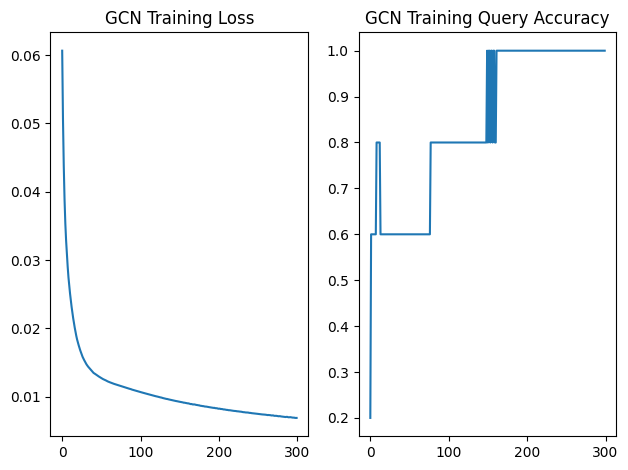

In [8]:
from torch_geometric.nn import GCNConv
from torch.nn import functional as F
class GCN(nn.Module):
    def __init__(self, num_features_inputs, embed1_size, embed2_size, num_classes_output):
        super().__init__()
        self.g_conv1 = GCNConv(num_features_inputs, embed1_size)
        #self.g_conv2 = GCNConv(embed1_size, embed2_size)
        self.out = nn.Linear(embed1_size, num_classes_output)

    def forward(self, x, edge_index, edge_weight):
        embedding = F.leaky_relu(self.g_conv1(x, edge_index, edge_weight=edge_weight))
        #embedding = F.leaky_relu(self.g_conv2(embedding, edge_index, edge_weight=edge_weight))
        out = self.out(embedding)
        return out
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# GCN训练
def gcn_train(gcn, graph_train_loader, query_size, num_epochs, lr, args:utils.Args):

    def init_weights(module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            #nn.init.normal_(module.weight, mean=0, std=1. / (10 ** 0.5))
        elif isinstance(module, torch_geometric.nn.GCNConv):
            nn.init.xavier_uniform_(module.lin.weight)
            #nn.init.normal_(module.lin.weight, mean=0, std=1. / (10 ** 0.5))

    def get_num_correct_query_pred(pred_y, y, query_size):
        return torch.sum(pred_y[-query_size:].argmax(dim=1) == y[-query_size:])

    optimizer = optim.Adam(gcn.parameters(), lr=lr)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)
    loss_function = nn.CrossEntropyLoss()
    gcn.to(args.device).train()
    gcn.apply(init_weights)
    fig, axes = plt.subplots(1, 2)

    losses, accs = [], []
    for epoch in range(1, num_epochs+1):
        metric = utils.Accumulator(4) # 一个epoch经过样本数 gcn一个epoch所有样本损失总量 一个epoch的query总数 一个epoch正确分类的query总数
        for graph in graph_train_loader:
            x, y = graph.x.to(args.device), graph.y.to(args.device)
            edge_index, edge_weight = graph.edge_index.to(args.device), graph.edge_weight.to(args.device)
            optimizer.zero_grad()
            y_hat = gcn(x, edge_index, edge_weight) + torch.tensor(1e-10)
            loss = loss_function(y_hat, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(x.shape[0], loss.item(),
                           query_size, get_num_correct_query_pred(y_hat, y, query_size))
            del x, y, edge_index, edge_weight
            torch.cuda.empty_cache()
                
        losses.append(metric[1] / metric[0])
        accs.append(metric[3]/metric[2])

        if epoch % 50==0:
            print(f"Epoch:{epoch}  |  GCN_Loss :{losses[-1]:.5f}  |  Query_Acc:{metric[3]/metric[2]*100:.2f}%")

    axes[0].plot(list(range(num_epochs)), losses)
    axes[0].set_title('GCN Training Loss')
    axes[1].plot(list(range(num_epochs)), accs)
    axes[1].set_title('GCN Training Query Accuracy')

    plt.tight_layout()
    res_folder = f"./Results/{args.N}-way-{args.K}-shots"
    if not os.path.exists(res_folder):
        os.makedirs(res_folder)
    plt.savefig(os.path.join(res_folder, f"{args.SNR}SNR-gcn-train-res-{args.N}-way-{args.K}-shots-"+args.transform))

gcn_embed1_size = 64
gcn_embed2_size = 16
gcn_num_epochs = 300
gcn_lr = 0.005
gcn = GCN(num_features_inputs=cnn_num_hidden_channels*2, 
          embed1_size=gcn_embed1_size, embed2_size=gcn_embed2_size, num_classes_output=args.N)
gcn_train(gcn, graph_trainloader, query_size,
            num_epochs=gcn_num_epochs, lr=gcn_lr, args=args)

图测试数据集中共有16张图
在第 1 张测试图中, 测试正确率为:73.33%
在第 2 张测试图中, 测试正确率为:70.00%
在第 3 张测试图中, 测试正确率为:60.00%
在第 4 张测试图中, 测试正确率为:73.33%
在第 5 张测试图中, 测试正确率为:73.33%
在第 6 张测试图中, 测试正确率为:80.00%
在第 7 张测试图中, 测试正确率为:60.00%
在第 8 张测试图中, 测试正确率为:70.00%
在第 9 张测试图中, 测试正确率为:66.67%
在第 10 张测试图中, 测试正确率为:66.67%
在第 11 张测试图中, 测试正确率为:80.00%
在第 12 张测试图中, 测试正确率为:66.67%
在第 13 张测试图中, 测试正确率为:76.67%
在第 14 张测试图中, 测试正确率为:70.00%
在第 15 张测试图中, 测试正确率为:80.00%
在第 16 张测试图中, 测试正确率为:73.33%
在测试集上的平均正确率:71.25%


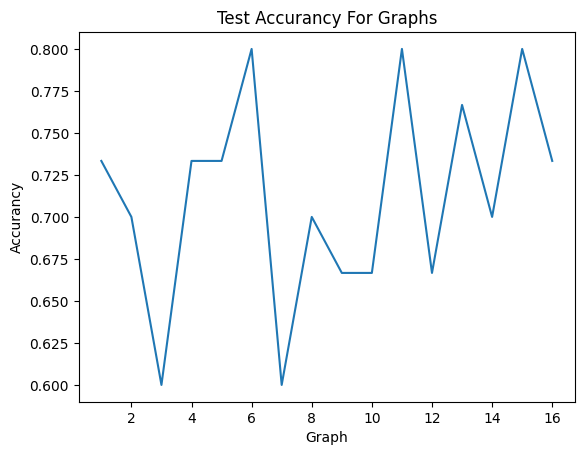

In [9]:
# GCN测试
test_graphs = to_graph_dataset(cnn, test_loader, device=args.device)
graph_testset = datasets.GraphDataset(graphs=test_graphs)
graph_testloader = GeometricDataLoader(graph_testset, batch_size=1, shuffle=False)
print(f"图测试数据集中共有{len(graph_testloader)}张图")
utils.gcn_test(gcn, graph_testloader, args)

In [11]:
#torch.save(cnn.state_dict, "cnn_params.pth")
print(mimii_dataset.N_classes)

['slider_id_06_abnormal', 'fan_id_02_abnormal', 'pump_id_02_abnormal', 'slider_id_04_abnormal', 'slider_id_04_normal']
